##Project Brief##

**Angel Flight West (AFW)** is a nonprofit that provides non-emergency medical air transportation for patients with financial constraints or other compelling needs. AFW delivers social impact with its platform where match volunteer pilots(supply) with patients(demand). In this project, I analyze the supply-side of the platform.

The following graph shows **the journey of an AFW command pilot**. Pilots need to register, complete command pilot orientation, and finally, fly a mission to be labeled “active”. Four pilot stages are investigated in our analysis and the definitions are as below.  The percentages in blues represents conversion rates based on the data from 2018 to 2016. As you can see, **there is  70% of pilots COULDN'T make through orientation**. I have ***two goals*** in this project as the following.


1.	Find the attributes that can be used to identify pilots who have higher chance to finish orientation and convert into command pilots so that marketing can adjust outreach strategies(Targeted-Markting)

2.	Build prediction model to predict whether registered pilots will convert into command pilots so that AFW can allocate its limited resource to help these high potential pilots get through the orientation accordingly 




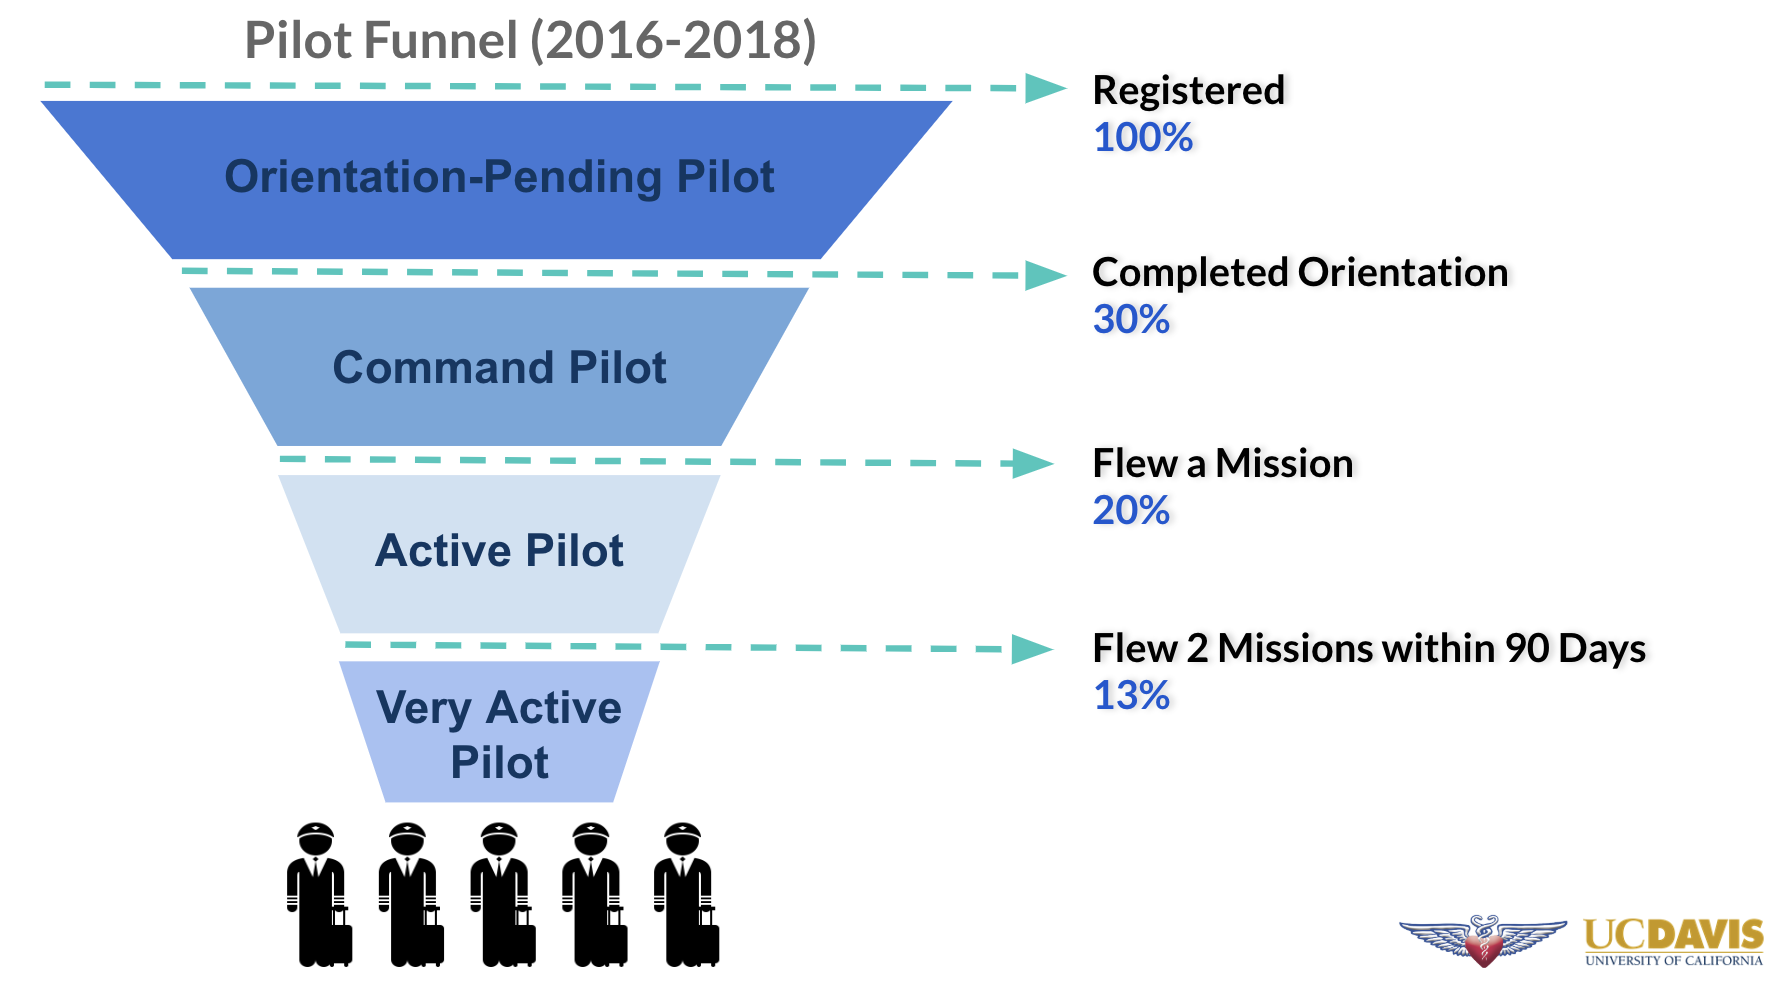

In [0]:
from IPython.display import Image
Image(filename="/content/drive/My Drive/Colab Notebooks/Profolio/Pilot Funnel.png",width = 600)

##1. Ingest

###1.1Mount Gogle Drive

In [1]:
#mount google drive 
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


###1.2 Import packages

In [0]:
#import the packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
#Common Model Helpers
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

###1.3 Load dataset and information


---

AFW has over 18 years data; however, I only use the data from 2016 to 2018. AFW dropped membership fee in 2012 and started Facebook advertising in 2016. I observed a big change of characteristics of pilots after these two events. Considering I was predicting and targeting pilots who would be similar to pilots registered after these two events, I determined only use data from 2016-2018.

In [3]:
#load the file from google drive 
pilots=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Profolio/Pilot_Orientation_Prediction.csv")

#get overview of dataset
pilots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 31 columns):
join_date                        1895 non-null object
join_year                        1895 non-null int64
active                           1895 non-null int64
flight_status                    1895 non-null object
co_pilot                         1895 non-null int64
date_of_birth                    1893 non-null object
age                              1893 non-null float64
total_hours                      1893 non-null float64
license_type                     1816 non-null object
ifr                              1895 non-null int64
multi_engine                     1895 non-null int64
mop_active_status                1895 non-null int64
oriented_date                    563 non-null object
join_orientated                  563 non-null float64
hseats                           97 non-null object
transplant                       0 non-null float64
profile_preferred_passengers     129 n

###1.4 Data Cleanning

In [4]:
#drop unneccessary columns or columns that with few datapoints
drop_list=['join_date','join_year','active','date_of_birth','date_of_birth','mop_active_status','oriented_date','join_orientated','hseats','transplant','profile_preferred_passengers','profile_max_passengers','profile_preferred_weight','profile_preferred_weight','profile_max_weight','profile_preferred_distance','profile_max_distance','profile_stops_preference','profile_medical_preference','profile_compassion_preference','profile_camps_preference','profile_veterans_preference','profile_children_preference','access','login']
pilots=pilots.drop(drop_list,axis='columns')
pilots['own'].fillna(0, inplace = True)
pilots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 8 columns):
flight_status    1895 non-null object
co_pilot         1895 non-null int64
age              1893 non-null float64
total_hours      1893 non-null float64
license_type     1816 non-null object
ifr              1895 non-null int64
multi_engine     1895 non-null int64
own              1895 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 118.5+ KB


In [5]:
#clean the null value
pilots= pilots.dropna()

#cross-check whether any null value in the dataset
pilots.isnull().values.any()

False

In [6]:
#check how many datapoint left after clean up null value
pilots.shape

(1814, 8)

###1.5 Formate transformation and classification


In [7]:
#Assign 0 to 'Orientation Pending'&'Orientation Not Pending' and 1 to 'Command Pilot'
pilots['status_code'] = np.where(pilots['flight_status']=='Command Pilot',1,0)

#Transfer str to number
pilots['license_code']=np.where(pilots['license_type']=='ATP',2,(np.where(pilots['license_type']=='Commercial',1, 0)))

#view data again
pilots.tail()

,flight_status,co_pilot,age,total_hours,license_type,ifr,multi_engine,own,status_code,license_code
1890,Orientation Pending,0,38.0,13000.0,Private,1,0,0.0,0,0
1891,Orientation Pending,0,40.0,10000.0,Private,1,0,1.0,0,0
1892,Orientation Pending,0,54.0,280.0,Private,1,0,1.0,0,0
1893,Orientation Pending,0,39.0,388.0,Private,1,0,1.0,0,0
1894,Orientation Pending,0,36.0,265.0,Private,0,0,1.0,0,0


##3.EDA##

###3.1 Create Correlation Heatmap to understand the most correlated columns

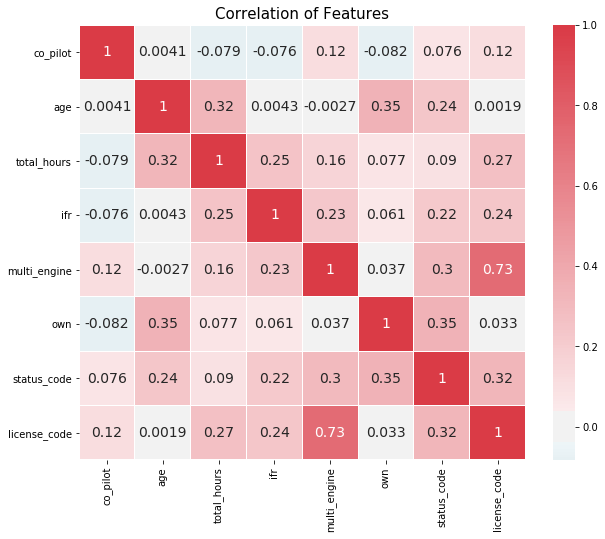

In [8]:
 #Review correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(10, 8))
    
    _ = sns.heatmap(
        df.corr(), 
        center=0,
        ax=ax,
        linewidths=0.1,
        cmap = sns.diverging_palette(220, 10, as_cmap=True),
        annot=True, 
        annot_kws={'fontsize':14 }
    )
    plt.title('Correlation of Features', y=1.05, size=15)

correlation_heatmap(pilots)

In [9]:
CP=pilots.loc[:,'status_code']==1
OP=pilots.loc[:,'status_code']==0
pilots[CP].head()

,flight_status,co_pilot,age,total_hours,license_type,ifr,multi_engine,own,status_code,license_code
0,Command Pilot,0,60.0,685.0,Commercial,1,0,0.0,1,1
1,Command Pilot,1,51.0,800.0,Commercial,1,1,1.0,1,1
2,Command Pilot,0,65.0,620.0,Commercial,1,1,0.0,1,1
4,Command Pilot,1,56.0,10890.0,ATP,1,1,0.0,1,2
6,Command Pilot,0,48.0,550.0,Private,1,0,1.0,1,0


###3.2 Review the distribution of age(numerical data)
The histogram below shows the distribution of command pilots(blue) and the orientation-pending(red). Orientation-pending pilots were yonger: between 20 to 45 years of age. Most commnad pilots were in their forties through their eighties.

Text(0.5, 1.0, 'Age Distribution')

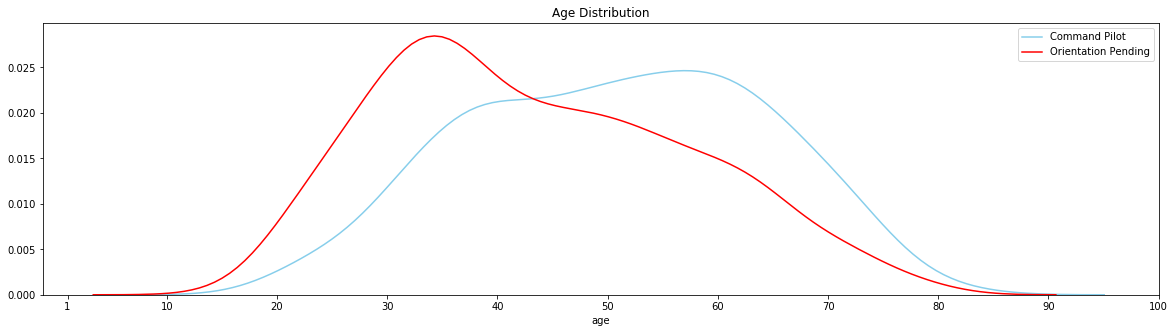

In [10]:
plt.subplots(figsize =(20, 5)) 
sns.distplot(pilots[CP]['age'] , color='skyblue', label='Command Pilot',hist=False)
sns.distplot(pilots[OP]['age'] , color='red', label='Orientation Pending',hist=False)
plt.xticks([1,10,20,30,40,50,60,70,80,90,100])
plt.title('Age Distribution' )

###3.3 Review the distribution of total flight hours(numerical data)
The histogram shows the distribution of command pilots(light blue) and the orientation-pending(light red). The differences in distribution are  not as obvious as with age, but there is still difference. Orientation-pending pilots were generally less experienced.


Text(0.5, 1.0, 'Total Flight Distribution')

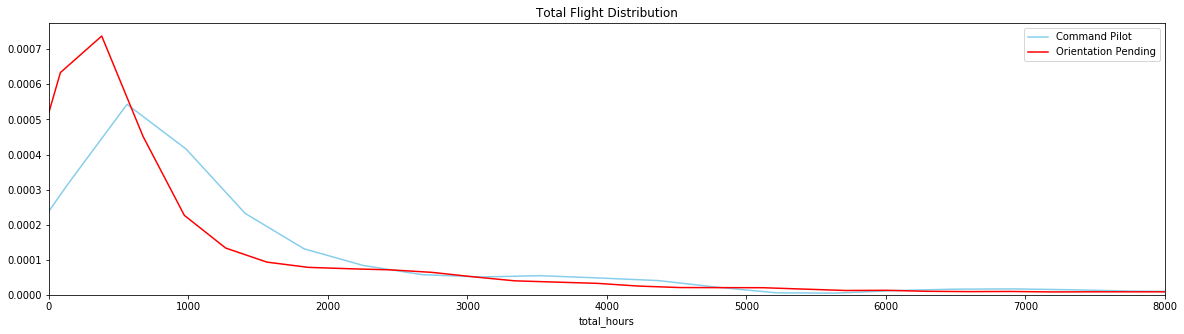

In [11]:
plt.subplots(figsize =(20, 5)) 
sns.distplot(pilots[CP]['total_hours'] , color='skyblue', label='Command Pilot',hist=False)
sns.distplot(pilots[OP]['total_hours'] , color='red', label='Orientation Pending',hist=False)
plt.xlim([0, 8000])
plt.title('Total Flight Distribution' )

###3.4 Review the distribution of all categorical data(co-pilot, instrument rating(ifr), multi-engine, license_type)
The data shows that command pilots are more likely to be instrument rating(ifr) and hold commercial, ATP and multi-engine licenses. They were also nearly twice as likely to own a plane.

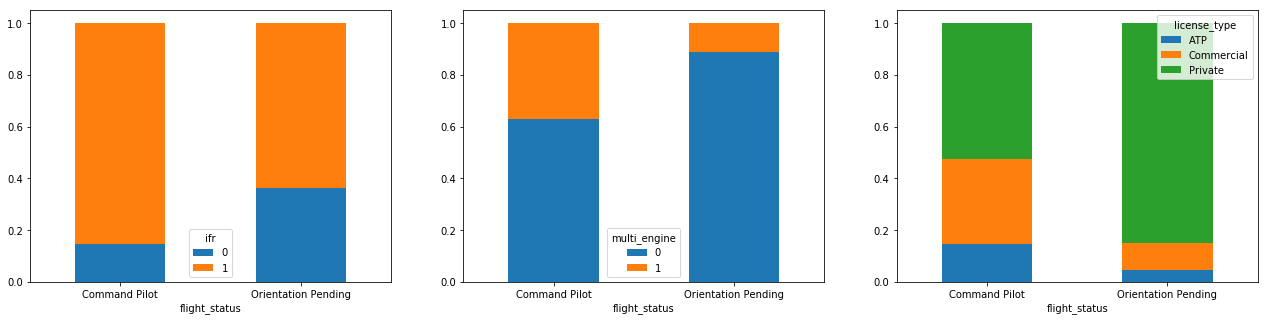

In [12]:
fig, (axis1,axis2,axis3) = plt.subplots(1, 3,figsize=(22,5))

ifr = pilots.groupby("flight_status")['ifr'].value_counts(normalize=True).unstack()
axis1=ifr.plot(kind='bar', stacked='True',ax = axis1,rot=360)

multi_engine = pilots.groupby("flight_status")['multi_engine'].value_counts(normalize=True).unstack()
multi_engine.plot(kind='bar', stacked='True',ax = axis2,rot=360)

license_type = pilots.groupby("flight_status")['license_type'].value_counts(normalize=True).unstack()
license_type.plot(kind='bar', stacked='True',ax = axis3,rot=360)


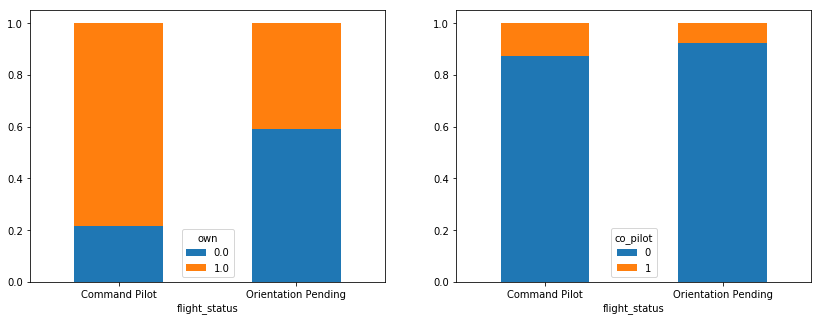

In [13]:
fig, (axis1,axis2) = plt.subplots(1, 2,figsize=(14,5))
own_plane = pilots.groupby("flight_status")['own'].value_counts(normalize=True).unstack()
own_plane.plot(kind='bar', stacked='True',ax = axis1,rot=360)

co_pilot = pilots.groupby("flight_status")['co_pilot'].value_counts(normalize=True).unstack()
co_pilot.plot(kind='bar', stacked='True',ax = axis2,rot=360)

##4. Feature Engineering##

###4.1 Bin the age based on life stage and age distribution plot above

In [14]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
bins_age = (0,20,30,55,80,120)
group_names_age = [ 'young','midle','before','after','senior']
pilots['age_bin'] = pd.cut(pilots['age'], bins = bins_age, labels = group_names_age)
label_quality = LabelEncoder()
pilots['age_bin'] = label_quality.fit_transform(pilots['age_bin'])
pilots['age_bin'].value_counts()

1    1039
0     498
2     254
4      21
3       2
Name: age_bin, dtype: int64

###4.2 Bin the total flight hours based on discussion with clients

In [15]:
bins_hours = (0,250,500,5000,10000)
group_names_hours = ['250','500','5000','12000']
pilots['total_hours_bin'] = pd.cut(pilots['total_hours'], bins = bins_hours, labels = group_names_hours)
label_quality = LabelEncoder()
pilots['total_hours_bin'] = label_quality.fit_transform(pilots['total_hours_bin'].astype(str))
pilots['total_hours_bin'].value_counts()

3    821
2    475
1    319
4    116
0     83
Name: total_hours_bin, dtype: int64

In [16]:
#review the output after bin
pilots.head()

,flight_status,co_pilot,age,total_hours,license_type,ifr,multi_engine,own,status_code,license_code,age_bin,total_hours_bin
0,Command Pilot,0,60.0,685.0,Commercial,1,0,0.0,1,1,0,3
1,Command Pilot,1,51.0,800.0,Commercial,1,1,1.0,1,1,1,3
2,Command Pilot,0,65.0,620.0,Commercial,1,1,0.0,1,1,0,3
3,Orientation Pending,0,29.0,1000.0,Private,0,0,0.0,0,0,2,3
4,Command Pilot,1,56.0,10890.0,ATP,1,1,0.0,1,2,0,4


##5.Modeling##

###5.1 Determine the Features

In [0]:
#Define y veriable as target
y=['status_code']

#Define x variables##remove SibSp based on the correlation
x=['co_pilot','age_bin','total_hours_bin','license_code','ifr','multi_engine','own']

###5.2 Split the Data

In [18]:
x_train, x_test, y_train, y_test = train_test_split(pilots[x],pilots[y], test_size=0.2)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1451, 7) (1451, 1)
(363, 7) (363, 1)


###5.3 Train and Select Model Based on Accuracy

In [87]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #SVM
    svm.SVC(probability=True),
    
    #xgboost: 
    XGBClassifier(base_score=0.05)    
    ]

#split dataset in cross-validation with this splitter class
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
#create table to compare MLA metrics
MLA_columns = ['MLA Name','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = y_train[y]

#index through MLA and save performance to table
row_index = 1
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    
    #score model with cross validation
    cv_results = model_selection.cross_validate(alg,x_train[x],  y_train[y], cv  = cv_split,return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3  
    

    #save MLA predictions 
    alg.fit(x_train[x],  y_train[y])
    MLA_predict[MLA_name] = alg.predict(x_train[x])
    
    row_index+=1

#print and sort table
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
1,SVC,0.776667,0.768349,0.0538283,0.105427
2,XGBClassifier,0.791724,0.76445,0.0462649,0.0496896


##6. Evaluate the Model

###6.1 Evaluate the Model with Confusion Metrix
I adjusted the threshold of XGBClassifier to lower the recall of 1 since I want to avoid the situation that the pilots have potential to become command pilots but the model predict they won't.

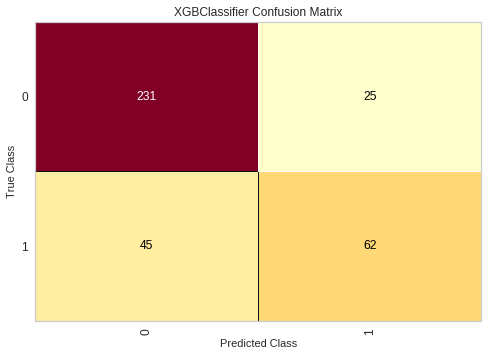

In [104]:
from yellowbrick.classifier import ConfusionMatrix
model=XGBClassifier(base_score=0.06) 

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=[0,1],threshold = 0.01)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(x_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(x_test, y_test)
cm.poof()

In [105]:
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test, model.predict(x_test))))

Classification report for classifier XGBClassifier(base_score=0.06, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1):
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       256
           1       0.71      0.58      0.64       107

    accuracy                           0.81       363
   macro avg       0.77      0.74      0.75       363
weighted avg       0.80      0.81      0.80       363




###6.2 Check the ROC ACU Curve

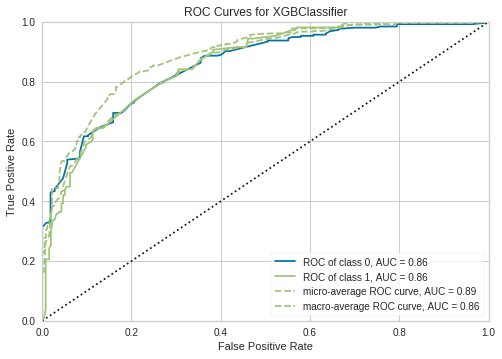

In [106]:
from yellowbrick.classifier import ROCAUC

model=XGBClassifier(base_score=0.06) 
classes=[0,1]

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(model, classes=classes)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

##7. Conclusion##

1. For outreach, while promoting AFW brand to broad audiences with Facebook advertising, AFW can include target marketing to experienced pilots and pilots who own a plane to increase the conversion rate (the ratio of pilot finishing orientation and become command pilots) because our analysis shows that command pilots tend to be more experienced than orientation.

2. For the prediction model, we have two objectives. One is to get high accuracy and the other is to have high recall for 1. Because the business implementation is to allocate AFW coordinators' resources to the pilots are predict as 1(have high potential to become command pilots) The accuracy is 81%; hoever, the recall for 1 is 58%, meaning almost 4 out 10 potential command pilots will be predicted as not converting. In this case, AFW can take the prediction results as reference while they try to approach pilots with orientation pending and prioritize the pilots who are predicted as 1. After they finish all the 1 cases they can still randomly working on those who were predict as 0. It will be better than their current opertion, which is approaching randomly, especially while the organization is with limited resources.